# Regression Diagnosis #

In [89]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm 
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import anderson
from scipy.stats import norm

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import get_fred_data

# Pretty Notation
from IPython.display import display, Math

In [90]:
# key

key = '0174cb93931388a2bf305663e4117fd3'

In [91]:
# Data for Y (Memorandum Items: Custody Holdings: Marketable U.S. Treasury Securities: Wednesday Level)
y_data = get_fred_data('WMTSECL1', key)

# Creating Time Index
y_data.index = pd.to_datetime(y_data.index)
y_data.name = 'holdings'

y_data

2002-12-18          0.0
2002-12-25          0.0
2003-01-01          0.0
2003-01-08          0.0
2003-01-15          0.0
                ...    
2025-03-12    2928628.0
2025-03-19    2945911.0
2025-03-26    2931015.0
2025-04-02    2929255.0
2025-04-09    2932857.0
Name: holdings, Length: 1165, dtype: float64

In [92]:
# Data for Explanatory Variables (Nominal Broad U.S. Dollar Index)
x_data = get_fred_data('DTWEXBGS', key)

# Time Index
x_data.index = pd.to_datetime(x_data.index)
x_data.name = 'dollar_index'

x_data

2006-01-02    101.4155
2006-01-03    100.7558
2006-01-04    100.2288
2006-01-05    100.2992
2006-01-06    100.0241
                ...   
2025-04-07    127.0629
2025-04-08    127.1122
2025-04-09    126.8819
2025-04-10    125.3694
2025-04-11    124.3156
Name: dollar_index, Length: 5030, dtype: float64

In [93]:
# Create the Data for Lineal Regression
ols_df = pd.DataFrame({'x': x_data, 'y': y_data})

# Eliminate 0s
ols_df = ols_df[(ols_df['x'] > 0) & (ols_df['y'] > 0)]

# Cut the Sample
ols_df = ols_df["2018-01-01":]

ols_df

,x,y
2018-01-03,109.6751,3014079.0
2018-01-10,109.6277,3017693.0
2018-01-17,108.1526,3017984.0
2018-01-24,107.0801,3013396.0
2018-01-31,106.7695,3032653.0
...,...,...
2025-03-12,126.1251,2928628.0
2025-03-19,126.0515,2945911.0
2025-03-26,126.4839,2931015.0
2025-04-02,126.6284,2929255.0


In [94]:
# We use Natural Log to calculate better betas
log_ols_df = np.log(ols_df)

# Drop NaNs
log_ols_df = log_ols_df.dropna()

# Set Index as a Date Item
log_ols_df.index = pd.to_datetime(log_ols_df.index)

log_ols_df

,x,y
2018-01-03,4.697522,14.918805
2018-01-10,4.697090,14.920003
2018-01-17,4.683543,14.920100
2018-01-24,4.673577,14.918578
2018-01-31,4.670672,14.924948
...,...,...
2025-03-12,4.837274,14.890045
2025-03-19,4.836691,14.895929
2025-03-26,4.840115,14.890859
2025-04-02,4.841257,14.890259


In [95]:
#Model specification
X_Matrix = sm.add_constant(log_ols_df[['x']])
X_Matrix = X_Matrix.values
Y_Vector = log_ols_df['y'].values

model = sm.OLS(
    Y_Vector, 
    X_Matrix
    )   
     
#the results of the model
results = model.fit() 

#here we check the summary
print(results.summary())     

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     724.0
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           7.58e-89
Time:                        14:02:26   Log-Likelihood:                 1107.7
No. Observations:                 369   AIC:                            -2211.
Df Residuals:                     367   BIC:                            -2203.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.8281      0.071    236.376      0.0

In [96]:
# Create the Residuals Series
residuals = results.resid

residuals = pd.Series(residuals, index = log_ols_df.index)
residuals.name = 'residuals'

residuals

2018-01-03   -0.022672
2018-01-10   -0.021647
2018-01-17   -0.026991
2018-01-24   -0.032515
2018-01-31   -0.027312
                ...   
2025-03-12    0.004695
2025-03-19    0.010345
2025-03-26    0.006651
2025-04-02    0.006509
2025-04-09    0.008541
Name: residuals, Length: 369, dtype: float64

In [97]:
# Breusch Pagan Test for Heteroskedasticity (null: homoskedasticity)

bp_test = het_breuschpagan(
    residuals, 
    sm.add_constant(log_ols_df['x'])
)

labels = ['LM statistic', 'p-value', 'F-statistic', 'F p-value']
print(dict(zip(labels, bp_test)))

{'LM statistic': 1.1472457652546735, 'p-value': 0.2841264504314061, 'F-statistic': 1.144586226421924, 'F p-value': 0.28538843706803896}


In [98]:
# White Test for Heteroskedasticity (null: homoskedasticity)

white_test = het_white(
    residuals, 
    sm.add_constant(log_ols_df['x'])
)

# Results
labels = ['Test Statistic', 'Test p-value', 'F-Statistic', 'F-Test p-value']
for name, value in zip(labels, white_test):
    print(f'{name}: {value:.4f}')

Test Statistic: 2.6650
Test p-value: 0.2638
F-Statistic: 1.3313
F-Test p-value: 0.2654


In [99]:
# Goldfeld-Quandt Test for Heteroskedasticity (null: homoskedasticity)

gq_test = het_goldfeldquandt(
    residuals, 
    sm.add_constant(log_ols_df['x'])
)

# Results
labels = ['F statistic', 'p-value', 'Alternative hypothesis']
for name, value in zip(labels, gq_test):
    print(f'{name}: {value}')

F statistic: 0.7142617642046937
p-value: 0.98821469264895
Alternative hypothesis: increasing


In [100]:
# Jarque Bera Test for Normality of Residuals (null: Normality)

jb_test = jarque_bera(residuals)

# Results
labels = ['JB statistic', 'p-value', 'skewness', 'kurtosis']
for name, value in zip(labels, jb_test):
    print(f'{name}: {value:.4f}')

JB statistic: 9.7748
p-value: 0.0075
skewness: -0.3825
kurtosis: 2.7754


In [101]:
# Anderson Darling Test for Normality of Residuals (null: Normality)

ad_test = anderson(residuals, dist='norm')

# Results
print(f"Statistic: {ad_test.statistic:.4f}")
print("Critical values:", ad_test.critical_values)
print("Significance levels:", ad_test.significance_level)

Statistic: 2.0892
Critical values: [0.57  0.649 0.779 0.908 1.08 ]
Significance levels: [15.  10.   5.   2.5  1. ]


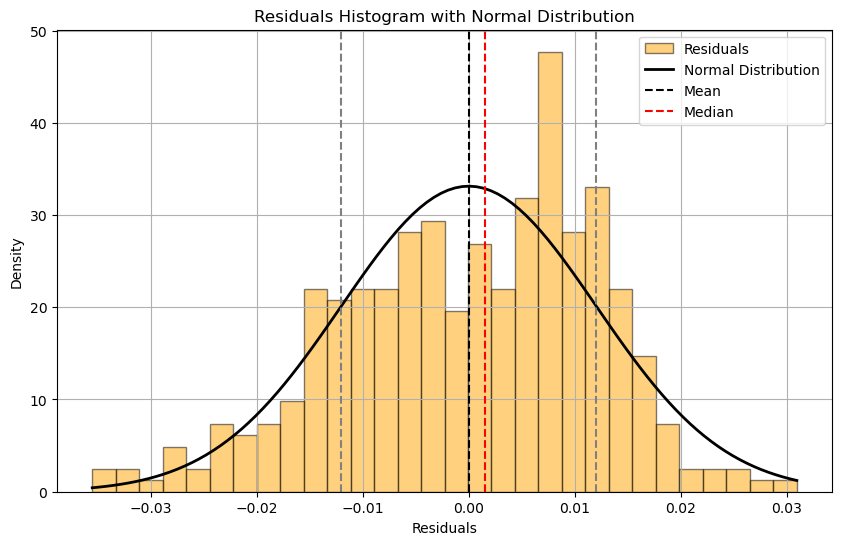

In [102]:
# Plot the Residuals Histogram

mu = residuals.mean()
sigma = residuals.std()
median = residuals.median()

# Create Histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, density=True, color='orange', alpha=0.5, edgecolor='black', label='Residuals')

# Generate the Values of the Normal Distribution
x = np.linspace(residuals.min(), residuals.max(), 100)
y = norm.pdf(x, mu, sigma)

# Graph the Real Normal Distribution
plt.plot(x, y, color='black', linestyle='solid', linewidth=2, label='Normal Distribution')

# Reference Lines
plt.axvline(x=mu, color='black', linestyle='dashed', label='Mean')
plt.axvline(x=median, color='red', linestyle='dashed', label='Median')
plt.axvline(x=mu + sigma, color='grey', linestyle='dashed')
plt.axvline(x=mu - sigma, color='grey', linestyle='dashed')

# Config
plt.title('Residuals Histogram with Normal Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')

# Legends and Grid
plt.legend()
plt.grid(True)

# Show
plt.show()

In [103]:
# Durbin Watson Test for First-Order Autocorrelation

# Calculate the Statistic
dw = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw:.4f}')

Durbin-Watson statistic: 0.1777


In [104]:
# Breusch-Godfrey Test for Autocorrelation (null: No Autocorrelation)
bg_test = acorr_breusch_godfrey(results, nlags=4) # we can adjust the lags

# Results
labels = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
for name, value in zip(labels, bg_test):
    print(f'{name}: {value:.4f}')

LM Statistic: 303.5918
LM p-value: 0.0000
F Statistic: 421.2159
F p-value: 0.0000


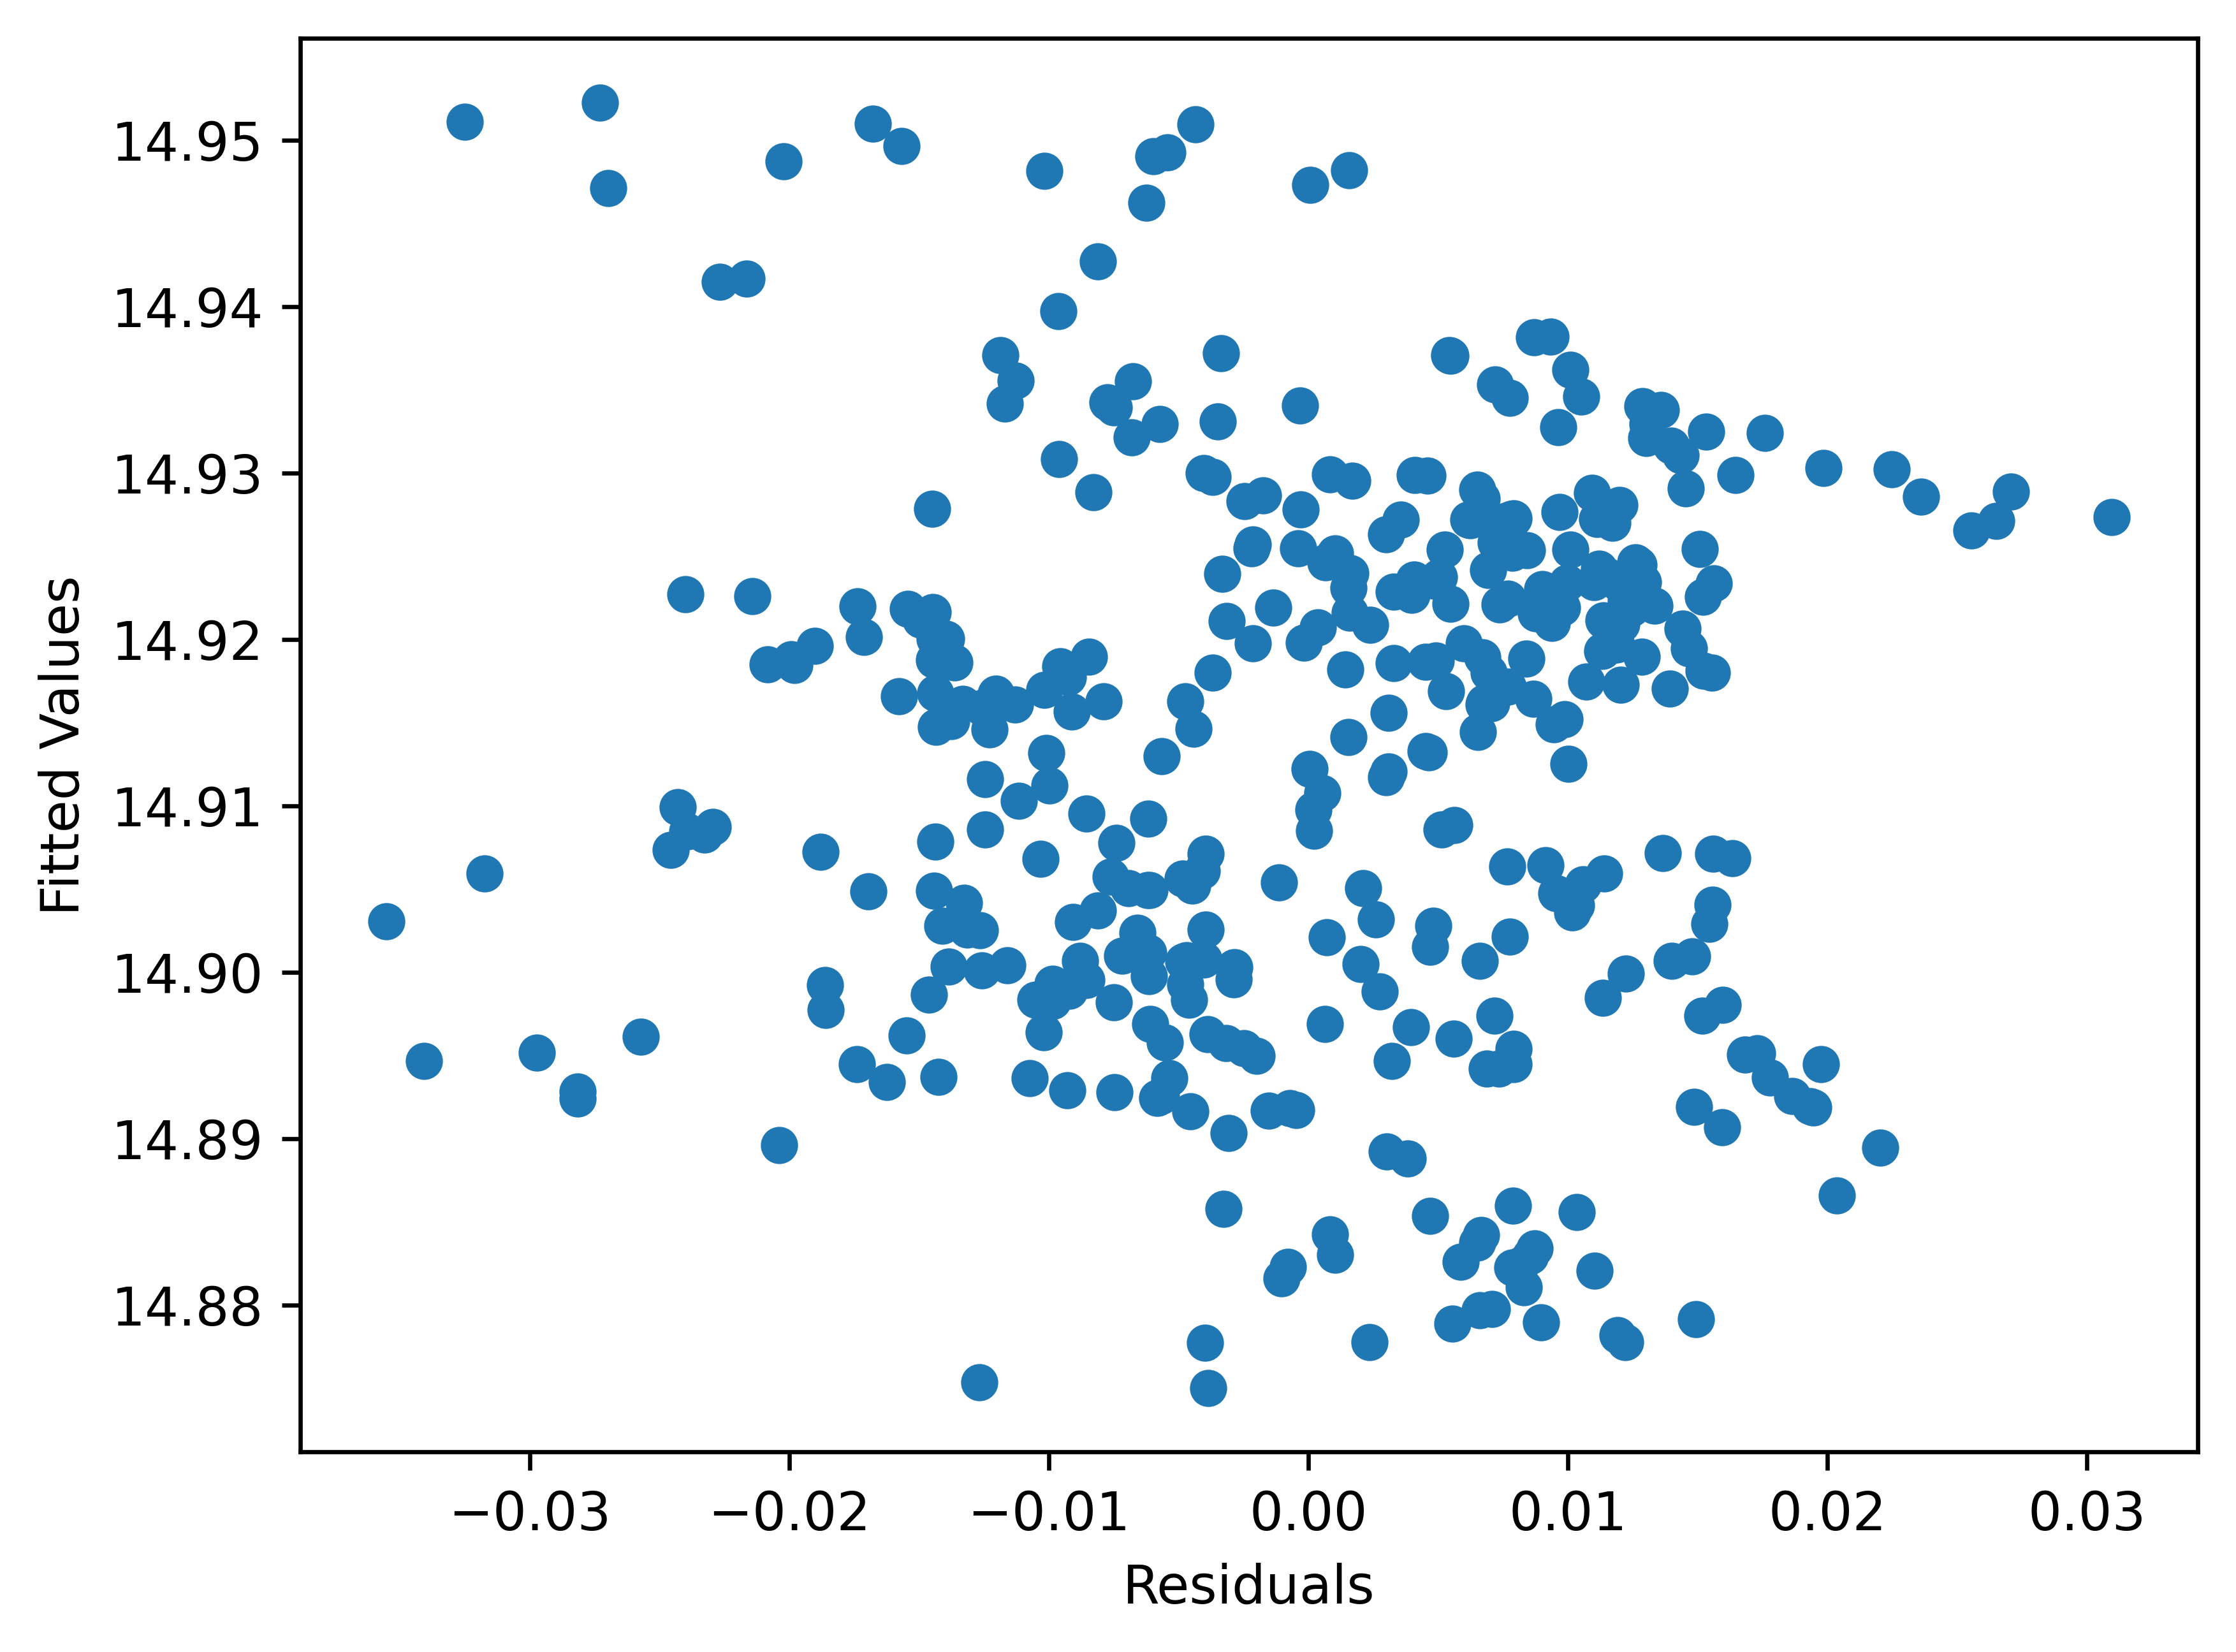

In [105]:
# Plot Residuals vs Fitted Values

y_fit = results.fittedvalues
y_fit = pd.DataFrame(y_fit, index=log_ols_df.index)
y_fit.name = 'fitted_values'

fig, ax1 = plt.subplots(dpi = 600)

plt.scatter(residuals, y_fit)
plt.ylabel('Fitted Values')
plt.xlabel('Residuals')

plt.show()

In [113]:
# Ramsey Test for Linearity (null: lineal model)

# Statistic
reset_test = linear_reset(results, power=2, use_f=True)

print(f"RESET F-statistic: {reset_test.fvalue:.4f}")
print(f"p-value: {reset_test.pvalue:.4f}")

RESET F-statistic: 0.3836
p-value: 0.5361


In [114]:
# Ramsey Test for Linearity (null: lineal model)

# Statistic
reset_test = linear_reset(results, power=3, use_f=True)

print(f"RESET F-statistic: {reset_test.fvalue:.4f}")
print(f"p-value: {reset_test.pvalue:.4f}")

RESET F-statistic: 24.3663
p-value: 0.0000
